Multi-level Texture Synthesisは速度や精度の面でそれなりに良い結果を出すことができるので、いくつか試すことにする。

In [1]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image

def multi_level_synthesis(path_to_texture_img, target_width=128, adding_noise=False):
    texture = cv2.imread(path_to_texture_img)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    print("texture image size is", texture.shape)

    target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
    img_display = display(Image.fromarray(target), display_id=True)

    ### item for algorithm
    current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
    current_target = cv2.resize(target, (target_width // 4, target_width // 4))
    neighbor_width = 8


    def init_anchors(target_width, neighbor_width, current_texture):
        indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
        x, y = np.meshgrid(indices, indices)
        target_anchors = np.column_stack((y.ravel(), x.ravel()))

        texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
        texture_anchors[:, 0] = np.random.randint(
            0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
        )
        texture_anchors[:, 1] = np.random.randint(
            0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
        )
        return target_anchors, texture_anchors

    target_anchors, texture_anchors = init_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    def update_anchors(target_width, neighbor_width, current_texture):
        indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
        x, y = np.meshgrid(indices, indices)
        target_anchors = np.column_stack((y.ravel(), x.ravel()))

        texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
        for i, target_anchor in enumerate(target_anchors):
            y, x = target_anchor
            result = cv2.matchTemplate(
                current_texture,
                current_target[y : y + neighbor_width, x : x + neighbor_width, :],
                method=cv2.TM_SQDIFF,
            )
            _, _, min_loc, _ = cv2.minMaxLoc(result)
            texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

        return target_anchors, texture_anchors

    loss_history = []
    phase = 0
    is_transiting = False

    iter = 1
    while iter < 100:
        iter += 1

        ### scheduling for neighbor_width and resolution
        if phase == 1 and is_transiting:
            is_transiting = False
            current_texture = cv2.resize(
                texture, (texture.shape[0] // 2, texture.shape[1] // 2)
            )
            current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
            neighbor_width = 16
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 2 and is_transiting:
            is_transiting = False
            neighbor_width = 8
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 3 and is_transiting:
            is_transiting = False
            current_texture = texture
            current_target = cv2.resize(current_target, (target_width, target_width))
            neighbor_width = 32
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 4 and is_transiting:
            is_transiting = False
            neighbor_width = 16
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 5 and is_transiting:
            is_transiting = False
            neighbor_width = 8
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 6:
            break

        current_texture_for_ref = current_texture.copy()
        # if adding_noise and iter < 50:
        #     # refer noisy texture
        #     noise = np.random.randint(0, 256, size=current_texture.shape, dtype=np.uint8)
        #     noisy_texture = cv2.addWeighted(current_texture, np.sqrt(iter / 50), noise, 1 - np.sqrt(iter / 50), 0)
        #     current_texture = noisy_texture

        # update target to argmin(E(target, texture))
        ref_for_pixel = [
            [] for _ in range(current_target.shape[0] * current_target.shape[1])
        ]

        for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
            y, x = target_anchor
            yy, xx = texture_anchor
            for i in range(neighbor_width):
                for j in range(neighbor_width):
                    ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                        current_texture_for_ref[yy + i, xx + j]
                    )

        loss = 0
        for y in range(current_target.shape[0]):
            for x in range(current_target.shape[1]):
                current_target[y, x] = np.mean(
                    ref_for_pixel[y * current_target.shape[1] + x], axis=0
                )
                loss += np.sum(
                    (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
                )

        mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
        print(f"iter {iter}: loss:{mse}")
        loss_history.append(mse)
        img_display.update(
            Image.fromarray(current_target)
        )

        # update texture reference points
        texture_anchors_prev = texture_anchors.copy()
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )

        if np.all(texture_anchors == texture_anchors_prev) or mse in loss_history[-3:-1]:
            phase += 1
            is_transiting = True
            print(f"transiting!!! phase {phase}")

        # add noise here
        if adding_noise and iter < 100:
            noise = np.random.randint(0, 256, size=current_target.shape, dtype=np.uint8)
            current_target = cv2.addWeighted(current_target, iter / 100, noise, 1 - (iter / 100), 0)
            img_display.update(Image.fromarray(current_target))

    plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.title("loss history")
    plt.show()

    target[:, :, :] = current_target
    display(Image.fromarray(target))

    now = datetime.now()
    now = now.strftime("%Y%m%d%H%M%S")
    Image.fromarray(target).save(f"synthesized_mul_texture_{now}.png")

texture image size is (64, 64, 3)


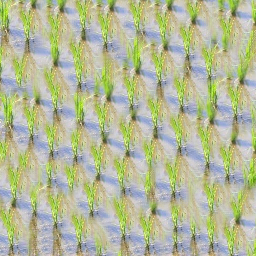

iter 2: loss:1242.319580078125
iter 3: loss:1178.3444010416667
iter 4: loss:1146.8345540364583
iter 5: loss:1140.098388671875
iter 6: loss:1133.89208984375
iter 7: loss:1127.4664713541667
iter 8: loss:1121.528076171875
iter 9: loss:1116.7574055989583
iter 10: loss:1115.0789388020833
iter 11: loss:1109.08349609375
iter 12: loss:1107.5777994791667
iter 13: loss:1106.4305826822917
iter 14: loss:1105.5716145833333
iter 15: loss:1104.78515625
transiting!!! phase 1
iter 16: loss:1097.104248046875
iter 17: loss:1084.327392578125
iter 18: loss:1074.5596313476562
iter 19: loss:1063.3560791015625
iter 20: loss:1055.1104532877605
iter 21: loss:1052.7733561197917
iter 22: loss:1050.530029296875
iter 23: loss:1050.003173828125
iter 24: loss:1045.9308471679688
iter 25: loss:1044.4752807617188
iter 26: loss:1043.3859252929688
iter 27: loss:1041.0490112304688
iter 28: loss:1040.4224243164062
iter 29: loss:1040.1001586914062
iter 30: loss:1040.0723266601562
iter 31: loss:1039.297627766927
iter 32: loss

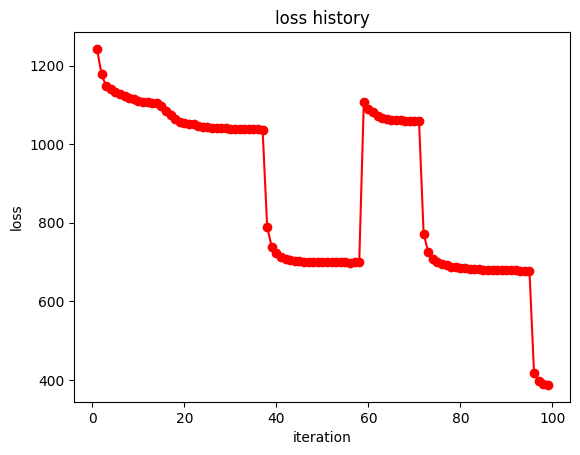

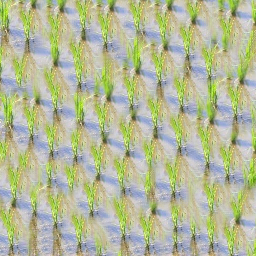

In [16]:
multi_level_synthesis("sample_images/ine_64.jpg", target_width=256)

texture image size is (64, 64, 3)


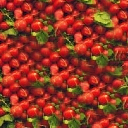

iter 2: loss:1039.3854166666667
iter 3: loss:985.47265625
iter 4: loss:971.6813151041666
iter 5: loss:968.1015625
iter 6: loss:938.4547526041666
iter 7: loss:936.0738932291666
iter 8: loss:918.2102864583334
iter 9: loss:900.4391276041666
iter 10: loss:903.0423177083334
iter 11: loss:901.1194661458334
iter 12: loss:893.0208333333334
transiting!!! phase 1
iter 13: loss:877.0327962239584
iter 14: loss:863.8863932291666
iter 15: loss:854.3831380208334
iter 16: loss:846.38916015625
iter 17: loss:829.2191569010416
iter 18: loss:821.303955078125
transiting!!! phase 2
iter 19: loss:657.66845703125
iter 20: loss:599.4100748697916
iter 21: loss:584.5054524739584
iter 22: loss:578.6097819010416
iter 23: loss:575.0520833333334
iter 24: loss:572.3855794270834
iter 25: loss:572.175537109375
iter 26: loss:572.159912109375
iter 27: loss:573.0453287760416
iter 28: loss:572.1348470052084
transiting!!! phase 3
iter 29: loss:870.0883992513021
iter 30: loss:854.6913859049479
iter 31: loss:849.3233642578125

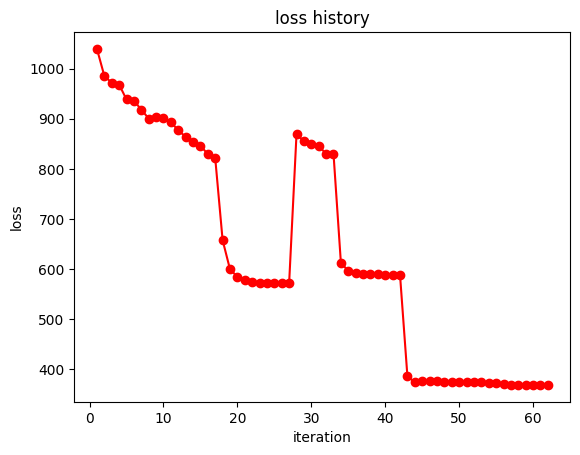

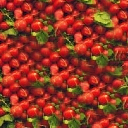

In [5]:
multi_level_synthesis("sample_images/kudamono_64.jpg")

texture image size is (64, 64, 3)


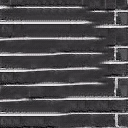

iter 2: loss:1147.861328125
iter 3: loss:1008.8059895833334
iter 4: loss:966.0511067708334
iter 5: loss:942.4599609375
iter 6: loss:906.8707682291666
iter 7: loss:873.6396484375
iter 8: loss:847.5638020833334
iter 9: loss:828.0846354166666
iter 10: loss:821.6025390625
iter 11: loss:820.830078125
iter 12: loss:817.3720703125
iter 13: loss:814.2916666666666
iter 14: loss:809.3785807291666
transiting!!! phase 1
iter 15: loss:866.0503743489584
iter 16: loss:850.9681803385416
iter 17: loss:837.888427734375
iter 18: loss:835.31005859375
iter 19: loss:835.90283203125
iter 20: loss:833.42236328125
iter 21: loss:838.544189453125
iter 22: loss:835.4051920572916
iter 23: loss:833.815673828125
transiting!!! phase 2
iter 24: loss:769.0653483072916
iter 25: loss:688.8694661458334
iter 26: loss:651.1021321614584
iter 27: loss:640.7347819010416
iter 28: loss:634.9541829427084
iter 29: loss:632.4480794270834
iter 30: loss:631.019775390625
iter 31: loss:630.5387369791666
iter 32: loss:630.1240234375
tra

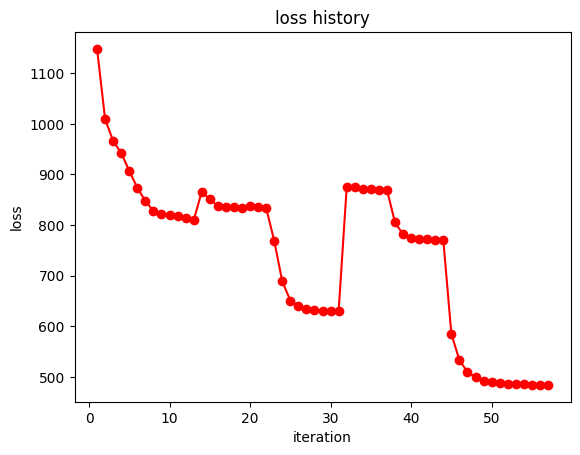

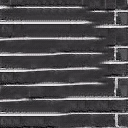

In [3]:
multi_level_synthesis("sample_images/renga_64.jpg")

texture image size is (64, 64, 3)


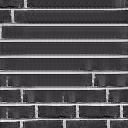

iter 2: loss:1140.8277994791667
iter 3: loss:1139.9713541666667
iter 4: loss:1122.83203125
iter 5: loss:1117.0169270833333
iter 6: loss:1090.0221354166667
iter 7: loss:1051.857421875
iter 8: loss:1030.505859375
iter 9: loss:972.59765625
iter 10: loss:967.4088541666666
iter 11: loss:929.8453776041666
iter 12: loss:907.8772786458334
iter 13: loss:888.0400390625
iter 14: loss:877.7434895833334
iter 15: loss:880.3984375
iter 16: loss:855.6165364583334
iter 17: loss:875.0279947916666
iter 18: loss:853.7483723958334
iter 19: loss:840.7737630208334
iter 20: loss:825.1360677083334
iter 21: loss:794.5387369791666
iter 22: loss:780.833984375
iter 23: loss:799.5843098958334
iter 24: loss:785.1754557291666
iter 25: loss:773.9638671875
iter 26: loss:791.216796875
iter 27: loss:757.6878255208334
iter 28: loss:737.1634114583334
iter 29: loss:765.2275390625
iter 30: loss:743.0865885416666
iter 31: loss:733.2770182291666
iter 32: loss:724.8600260416666
iter 33: loss:712.6044921875
iter 34: loss:699.680

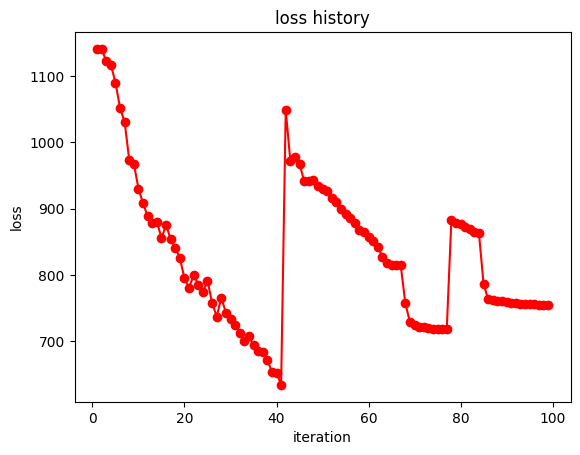

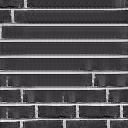

In [4]:
multi_level_synthesis("sample_images/renga_64.jpg", adding_noise=True)

texture image size is (64, 64, 3)


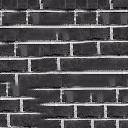

iter 2: loss:1137.1009114583333
iter 3: loss:1027.4908854166667
iter 4: loss:987.09375
iter 5: loss:957.2477213541666
iter 6: loss:938.8961588541666
iter 7: loss:916.4108072916666
iter 8: loss:904.6884765625
iter 9: loss:888.4111328125
iter 10: loss:872.1848958333334
iter 11: loss:868.1061197916666
iter 12: loss:842.9156901041666
iter 13: loss:840.8128255208334
iter 14: loss:839.205078125
iter 15: loss:833.4860026041666
iter 16: loss:827.0875651041666
transiting!!! phase 1
iter 17: loss:985.0653483072916
iter 18: loss:987.32958984375
iter 19: loss:986.1427408854166
iter 20: loss:957.4349772135416
iter 21: loss:938.2721354166666
iter 22: loss:939.6123860677084
iter 23: loss:917.4456380208334
iter 24: loss:902.1490071614584
iter 25: loss:881.1514485677084
iter 26: loss:880.8199869791666
iter 27: loss:867.56982421875
iter 28: loss:848.9085286458334
iter 29: loss:825.2237955729166
iter 30: loss:808.76123046875
iter 31: loss:798.94580078125
iter 32: loss:794.8116861979166
iter 33: loss:783.

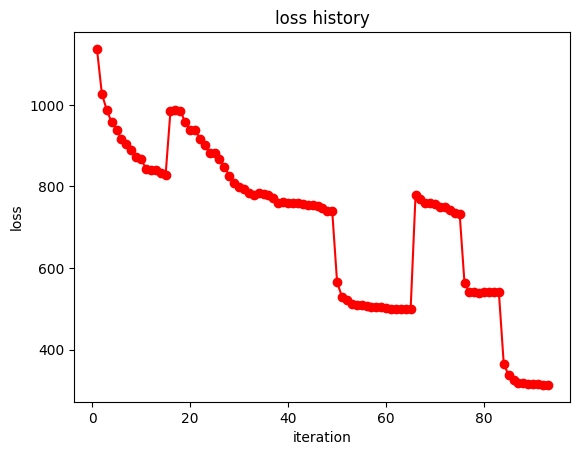

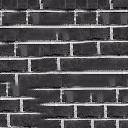

In [15]:
multi_level_synthesis("sample_images/renga_64.jpg", adding_noise=True)